# Триангуляция Делоне. Динамический алгоритм: удаление и вставка

## Содержание

- [Задача](#prob)
- [Базовые определения](#def)
- [Визуализация](#visual)
- [Дополнительные определения](#adddef)
- [Алгоритм вставки](#insert)
- [Алгоритм удаления](#remove)
- [Время работы](#time)

## Задача <a id="prob"></a>

Для данной триангуляции Делоне множества точек необходимо научиться выполнять **вставку** некоторой точки в триангуляцию и **удаление** некоторой точки.

## Базовые определения <a id="def"></a>

**Подразбиение Делоне множества точек** — такое разбиение выпуклой оболочки множества точек на множество выпуклых фигур, что в окружности, описанной вокруг любой из фигур, не находится никаких точек из множества.

**Триангуляция Делоне множества точек** — триангуляция, являющаяся подразбиением Делоне.


***Примечание:*** *для понимания дальнейшего материала необходимо сначала ознакомиться с базовой теорией о триангуляции Делоне, однородных координатах, а также со структурой данных DCEL.*(и тут ссылки на ноутбуки)

## Визуализация <a id="visual"></a>
Блок ниже запускает визуализацию удаления и вставки точки в триангуляцию.<br> 
Клик по точке в триангуляции удаляет эту точку.<br>
Клик в любом месте кроме точек из триангуляции добавляет точку места клика в триангуляцию.<br>
Измененная точка отображается желтым цветом.

<IPython.core.display.Javascript object>


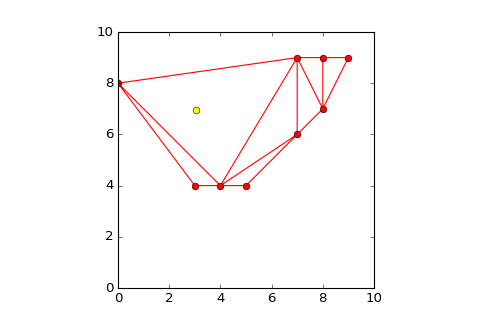

In [1]:
%matplotlib notebook
from add_del_visualize import visualize
visualize()

## Дополнительные определения и леммы для динамической триангуляции <a id="adddef"></a>
 <img src="Pictures/flip.png" style="float: right; width: 180px;"/>
**Локальный критерий Делоне для ребра** — пара треугольников, которым принадлежит это ребро, является триангуляцией Делоне вершин этих треугольников (то есть вершина, противолежащая ребру в одном треугольнике, не лежит в окружности, описанной вокруг другого треугольника, и наоборот).


На рисунке справа локальный критерий Делоне выполнен только для синего ребра.

Будем называть **хорошими** те рёбра, для которых выполняется локальный критерий Делоне.

Рассмотрим пару смежных треугольников. Рёбра этих треугольников образуют четырёхугольник с проведённой в нём диагональю. Если этот четырёхугольник выпуклый, то возможна операция замены этой диагонали на другую, такая операция называется **флип (flip)**.

<img src="Pictures/Flip2.png" style="float: right; width: 320px;"/>
На рисунке справа флип переводит красное ребро в синее.


**Замечание:** Если два смежных с ребором треугольника образуют невыпуклый четырёхугольник, то это ребро является хорошим. 


**Глобальный критерий Делоне для триангуляции** — ни одна из окружностей, описанных вокруг треугольников из триангуляции не содержит других точек кроме вершин этого треугольника.
#### Лемма

<img src="Pictures/Global.png" style="float: right; width: 200px;"/> 

Если для всех ребер триангуляции выполнен локальный критерий Делоне, то для неё выполнен и глобальный критерий Делоне.
<br>$\triangleright$<br><div style="padding-left:40px">
Докажем методом от противного. Предположим, что все ребра хорошие, но существует точка $E$, которая пренадлежит некоторым треугольникам из триангуляции и не является их вершиной. Из всех таких треугольников выберем $ABC$, такой что угол $\angle{BEC}$ максимален, при $BC$ ближайшей стороне к точке $E$. 

Рассмотрим треугольник $BCD$ смежный с $ABC$. Так как ребро $BC$ хорошее, то $D$ лежит вне его описанной окружности, значит, $\angle{BAC} + \angle{BDC} < 180^{\circ}$. Так как $E$ лежит внутри описанной окружности $ABC$, то $\angle{BAC} + \angle{BEC} > 180^{\circ}$. Из полученных неравенств следует, что $\angle{BEC} > \angle{BDC}$. Значит, точка $E$ лежит внутри описанной окружности треугольника $BCD$. А так как $\angle{BED} > \angle{BEC}$ получили противоречие с условием выбора треугольника $ABC$.
</div>$\triangleleft$


Необходимо также понимать, что триангуляция Делоне является нижней выпуклой оболочкой точек, поднятых на параболоид, где мы считаем, что существует бесконечно удаленная по оси $z$ точка, которая образует бесконечные треугольные грани с крайними точками из оболочки.
<img src="Pictures/paraboloid.png" style="float: center; width: 500px;"/> 

<img src="Pictures/lemma1.png" style="float: right;" />
#### Лемма 1
Флип плохого ребра заменяет его хорошим.
<br>$\triangleright$<br><div style="padding-left:40px">
Докажем, что из двух рёбер, которые можно провести для пары треугольников, как минимум одно хорошее.<br>
Предположим, что это не так, то есть оба ребра (назовём их $AB$ и $CD$) плохие. Рассмотрим четырёхугольник $ACBD$ и окружность, описанную вокруг треугольника $ABC$. Точка $D$ лежит внутри этой окружности, значит, сумма углов $C$ и $D$ больше $180^{\circ}$. Аналогично доказывается, что сумма углов $A$ и $B$ больше $180^{\circ}$. Значит, сумма углов четырёхугольника $ACBD$ больше $360^{\circ}$, что невозможно.<br>
</div>$\triangleleft$

<img src="Pictures/Good_edge.png" style="float: right;" />
#### Лемма 2

Если в триангуляцию Делоне вставить точку в некоторый треугольник и соединить его вершины с этой точкой, то получившиеся рёбра будут хорошими.
<br>$\triangleright$<br><div style="padding-left:40px">
Предположим, точка была вставлена не на ребро. Рассмотрим любое из рёбер — пусть это будет ребро $VC$. Проведём окружность, описывающую треугольник $ABC$. По критерию Делоне в ней не будет никаких точек триангуляции. На ребре $VC$ можно построить окружность, изнутри касающуюся окружности, описанной вокруг треугольника. В ней тоже нет никаких точек. Значит, для $VC$ выполняется критерий Делоне для рёбер, значит, ребро должно принадлежать триангуляции с добавленной точкой $V$, значит, оно хорошее.
    
Случай, когда точка вставляется на ребро, рассматривается аналогично.<br>
</div>$\triangleleft$

## Алгоритм вставки <a id="insert"></a>

### Краткий план алгоритма

1. Определяем, в каком фейсе (или на каком ребре) лежит точка. Для этого используем алгоритм локализации (ссылка)
2. Добавляем три ребра, сам фейс превращаем в один из новых смежных с вставляемой точкой и добавялем ещё два фейса.
3. Плохие ребра с помощью флипов заменяем на хорошие.


#### Пример <br>
| [![First](Pictures/first.png)](first)  | [![Second](Pictures/second.png)](second) | [![Third](Pictures/third.png)](third) |
|:---:|:---:|:---:|
| Триангуляция до выполниения вставки | Состояние после второго шага (зеленые ребра появились, синие ребра стали плохими)| Триангуляция после третьего шага |

### Подробности реализации алгоритма вставки

Пусть $q$ — вставляемая точка. <br>
**Заметим**, что все добавленные в пункте 2 ребра по **лемме 2** являются хорошими. Плохими могут стать ребра противолежащие точке $q$. После пункта 1 мы имеем три таких ребра. Рассмотрим выпуклый четыехугольник, в котором происходит флип. Этот четырехугольник имеет ровно два ребра инцидентных $q$, флип порождат еще одно такое ребро. Ровно два ребра четырехугольника, которые не были инцидентны $q$, становятся противолежащими $q$ и могут оказаться плохими (докажем это в **лемме 3**).<br>

| [![Lemmaa](Pictures/Flip3.png)](lemmaa)|
|::|
|Ребро $CE$ флипается в ребро $FD$, рёбра $CD$ и $DE$ могут оказаться плохими|

<br>
Будем добавлять потенциально плохие ребра в очередь. При обработке очередного ребра из очереди будет происходить либо флип с добавлением двух рёбер в очередь в случае, если ребро плохое, либо пропуск ребра, если оно хорошее.<br>
Докажем, что этот процесс завершится, с помощью **леммы 4** и **леммы 5**.


#### Лемма 3

При вставке точки будут флипаться только рёбра, противолежащие вставленной точке.
<br>$\triangleright$<br><div style="padding-left:40px">
Доказательство по индукции.

База. По **лемме 2** изначально не будут флипаться новые рёбра, инцидентные точке, то есть плохими могут оказаться только рёбра, противолежащие точке.

Переход. Рассмотрим, что произойдёт с противолежащим точке $V$ ребром $AC$ после флипа, если оно плохое. До вставки точки $V$ для триангуляции выполнялся глобальный критерий Делоне, поэтому в окружности, описанной вокруг треугольника $ACD$, не будет лежать никаких точек, кроме точки $V$. Можно построить окружность, касающуюся её изнутри в точке $D$ и проходящую через точку $V$. В ней тоже не окажется никаких точек, так как она касается изнутри. Значит, для ребра $VD$ выполняется критерий Делоне. Значит, после флипа ребро $AC$ уже не будет флипаться. Так как для рёбер $AV$ и $CV$ выполняется критерий Делоне, то плохими после флипа могут стать только рёбра $AD$ и $CD$ — то есть рёбра, противолежащие точке $V$.
</div>$\triangleleft$

| [![Lemma3](Pictures/lemma3.png)](lemma3)|
|::|
|$V$ — вставленная точка, ребро $AC$ — плохое|


#### Лемма 4

 Флип плохого ребра уменьшает разность объёмов параболоида и триангуляции, спроецированной на него.

$\triangleright$

<div style="padding-left:27px" >
Рассмотрим два таких смежных треугольника, что ребро между ними является плохим. Спроецируем их на параболоид. Четыре точки, принадлежащие смежным треугольникам, при проекции на параболоид образуют тетраэдр.<br>
Проведём через любой из двух треугольников плоскость. Вершина, противолежащая основанию тетраэдра, являющегося этим треугольником, лежит ниже этой плоскости (так как не выполняется локальный критерий Делоне), то есть тетраэдр лежит ниже тела, образующегося при проекции всей триангуляции на параболоид.
После флипа станет выполняться локальный критерий Делоне, то есть тело станет включать в себя тетраэдр. Поэтому после флипа плохого ребра объём тела увеличится на объём этого тетраэдра.
</div>

$\triangleleft$

#### Лемма 5

 Любая триангуляция сводится к триангуляции Делоне за конечное число флипов.

$\triangleright$

<div style="padding-left:27px" >
Всего триангуляций заданного множества точек конечное число, и среди них есть триангуляция Делоне. Последовательность флипов плохих рёбер триангуляции образует такую последовательность триангуляций, что разность объёмов параболоида и спроецированной на него триангуляции убывает (по **лемме 4**). Эта последовательность конечна (при этом последней в последовательности является триангуляция Делоне), значит, число флипов, требуемых для достижения триангуляции Делоне, тоже конечно.
</div>

$\triangleleft$

**Замечание 1** <br> 
Если вставляемая точка попадает на ребро, на шаге 2 получится треугольник с углом в $180^{\circ}$, в котором это ребро является противолежащим вставляемой точке. Тогда оно попадет в очередь и в некоторый момент произойдет флип этого ребра, так как оно стало плохим для новой триангуляции.


**Замечание 2** <br>
Вставка точки, не лежащей внутри выпуклой оболочки имеющихся точек, сводится к обычной вставке точки, благодаря предположению о существовании бесконечно удаленной по оси $z$ точки, имеющей координаты $(0,0,1,0)$ (последняя координата — однородная).


## Алгоритм удаления <a id="remove"></a>

### Краткий план алгоритма
1. 1а. Если у точки три или менее инцидентных ребра, перейдем к шагу 2. <br> 
   1б. Иначе будем флипать рёбра инцидентные удаляемой точке в некотором порядке, пока не останется ровно три ребра.
2. Удалим точку и инцидентные ей рёбра.

### Порядок флипов
Пусть $p$ — удаляемая точка, $\{q_0, q_1, \ldots, q_n = q_0\}$ — смежные с $p$ точки в порядке обхода против часовой стрелки. Пусть точки $p$ и $q_i$ задают очередное ребро. Заметим, что точки $p$, $q_{i-1}$, $q_i$, $q_{i+1}$, поднятые на параболоид, образуют тетраэдр. Будем флипать рёбра в порядке увеличения высоты соответствующих тетраэдров. В данном алгоритме будем использовать высоту со знаком, где высота принимает отрицательное значение, если точка $p$ находится под плоскостью $q_{i-1}q_iq_{i+1}$ и положительное иначе.

### Лемма
Рассмотрим многоугольник $H = \{q_0, q_1, \ldots , q_{k−1}, q_k = q_0\}$ и точку $p$, такие что ребра $q_iq_{i+1}$ принадлежат триангуляции Делоне точек $\{q_0, q_1, \ldots , q_{k−1}, p\}$. Тогда если абсолютное значение высоты тетраэдра $p \, q_i \, q_{i+1} \, q_{i+2}$ из точки $p$ максимально, то ребро $q_iq_{i+2}$ принадлежит триангуляции Делоне для точек $\{q_0, q_1, \ldots , q_{k−1}\}$.

### Подробности реализации
Так как после флипа ребра $pq_i$ у точек $q_{i-1}$ и $q_{i+1}$ меняется один сосед в обходе (они становятся соседними друг с другом вместо $q_i$), будем поддерживать приоритетную очередь, где значения — рёбра из точки $p$, а ключи — высоты соответствующих тетраэдров, и после флипа обновлять значения.

Высоту будем вычислять по формуле: <br>
$h(p,q_{i-1},q_i,q_{i+1}) = \frac{
\begin{vmatrix}
q_{i-1(x)}                    & q_{i(x)}                    & q_{i+1(x)}                    & p_{(x)}                 & \\ 
q_{i-1(y)}                    & q_{i(y)}                    & q_{i+1(y)}                    & p_{(y)}                 & \\ 
q_{i-1(x)}^2 + q_{i-1(y)} ^ 2 & q_{i(x)}^2 + q_{i(y)} ^ 2   & q_{i+1(x)}^2 + q_{i+1(y)} ^ 2 & p_{(x)}^2 + p_{(y)} ^ 2 & \\ 
1                             & 1                           & 1                             & 1                       &
\end{vmatrix} } {
\begin{vmatrix}
q_{i-1(x)}                    & q_{i(x)}                    & q_{i+1(x)} & \\ 
q_{i-1(y)}                    & q_{i(y)}                    & q_{i+1(y)} & \\ 
1                             & 1                           & 1          &
\end{vmatrix}
}$


#### Пример <br>
| <img src="Pictures/del1.png " width="300px">  | <img src="Pictures/del2.png " width="300px"> | <img src="Pictures/del3.png " width="300px"> |
|:---:|:---:|:---:|
| Триангуляция до выполниения удаления |После всех флипов (синим обозначены новые рёбра)|Триангуляция после удаления точки |

## Время работы <a id="time"></a>

### Вставка

#### Лемма 6
Средняя степень вершины после вставки её в триангуляцию Делоне равна $O(1)$.
<br>$\triangleright$<br><div style="padding-left:40px">
Так как триангуляция представляет собой планарный граф, применима формула Эйлера и следствие из него: для связного планарного графа с $V$ вершинами и $E$ ребрами выполнено неравенство $E \le 3V - 6$. Тогда среднюю степень вершины можно оценить как $d_{average}= \frac{2E}V \le 2 \cdot \frac{3V - 6} V = O(1)$
<br></div>$\triangleleft$

**Теорема** <br>
При вставке точки в триангуляцию Делоне в среднем придётся сделать $O(1)$ флипов.
<br>$\triangleright$<br><div style="padding-left:40px">
Все флипнутые рёбра окажутся инцидентными вставленной точке (**по лемме 3**), а степень вершины — $O(1)$ (**по лемме 6**). Поэтому будет сделано $O(1)$ флипов.
<br></div>$\triangleleft$


**Замечание 1** <br>
Существует такой порядок добавления точек, что построение триангуляции с $n$ точками будет работать за $O(n^2)$. Поэтому важно добавлять точки в случайном порядке, тогда будет выполняться средняя оценка на время — $O(n)$.

**Замечание 2**<br>
Так как среднее число флипов — $O(1)$, то время вставки целиком зависит от времени локализации.

### Удаление

Средняя степень вершины в триангуляции — $O(1)$, так как при удалении обрабатываются только инцидентные вершине ребра, то среднее число флипов будет также $O(1)$.